# dataset that plays nice with pytorch dataloader (fancy/efficient iterator)

In [3]:
import os, json
from collections import Iterable
from functools import partial

import numpy as np
import pandas as pd
from PIL import Image
from IPython.core.display import display

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from torch.utils.data.dataloader import default_collate as collate

In [69]:
def loadPILImages(paths, mode='L', *args, **kwargs):
    tensors = []
    for path in paths:
        with open(path, 'rb') as f:
            img = Image.open(f)
            tensors += [transforms.ToTensor()(img.convert(mode))]
    return tensors

def loadH5images(paths, channels=(3,2,4), *args, **kwargs):
    tensors = []
    for path in paths:
        f = h5py.File(path, 'r')
        image = f['image'].value[channels, ::]
        image = eight_bit_to_float(image)
        tensors += [torch.from_numpy(image)]
    return tensors


class DatasetDataframe(Dataset):
    """general dataframe Dataset class"""

    def __init__(self, df,
                 tabularData={'outName1':'colName1', 'outName2':'colName2'},
                 imageData={'image1':{'cols':['channel1colName', 'channel2colName']}, 'image2':{'cols':['RGBimagecolName']}}):
        """
        Args:
            df (pandas.DataFrame): dataframe containing tabular data and/or the absolute paths to image locations
            tabularData: dict whos values are column names in df whose entries will be returned for each data point, the names when returned will be the keys of this dict.
                         Groups of colum names can be used for a value (eg generating an 'X' matrix) but should only be used for groups of numeric columns, not strings
                         Columns should contain either strings or numeric types convertable to torch rensors (int, np.float, etc)
            imageData: dict whose keys each specify the name of a returned image, and whose values specify how that image is loaded/constructed, via kewargs: 'cols', 'mode' 'transform', and 'aggregate'.
                       'cols' (list) specifies which columns in the df contain paths to images that will be transformed/aggregated to construct an output images
                       'mode' (string) specifies which mode PIL/Pillow load the image as, eg 'L' (greyscale), 'RGB', etc
                       'aggregate' (function) specifies how each individual tensor from the transformed images will be aggregated into one image tensor, e.g. torch.stack, torch.cat, etc
                       'transform' (function) specifies how aggregated image found in 'cols' will be transformed.
                           mostly useful for one or three channel images using transforms.ToPILImage(), your transforms, and then transforms.ToTensor() inside transforms.Compose([])
                           lambda transforms like transforms.Lambda(lambda x: mask*x) should work directly on tensors of any number of channels
        """
        self.opts = locals()
        self.opts.pop('self')
        self.opts.pop('df')
        self.df = df.reset_index(drop=True)
               
        for name,kwargs in self.opts['imageData'].items():
            defaultkwargs = {'loader':partial(loadPILImages, mode='L'), 'aggregate':torch.stack, 'transform':transforms.Compose([])}
            defaultkwargs.update(self.opts['imageData'][name]); self.opts['imageData'][name] = defaultkwargs
        
    def __len__(self):
        return len(self.df)

    def _get_item(self, idx):
        images = {name:kw['transform'](kw['aggregate'](kw['loader'](list(self.df.loc[idx,kw['cols']]))).squeeze(dim=1)) for name,kw in self.opts['imageData'].items()}
        tabular = {name:self.df[cols].iloc[idx] for name,cols in self.opts['tabularData'].items()}
        tabular = {name:(torch.from_numpy(value.values) if isinstance(value, pd.Series) else value) for name,value in tabular.items()}
        return {**images, **tabular}

    def __getitem__(self, idx):
        return collate([self._get_item(i) for i in idx]) if isinstance(idx,Iterable) else self._get_item(idx)

In [51]:
class DatasetFeatures(DatasetDataframe):
    def __init__(self, df, ycol='yCol', Xcols=['Xcol1', 'Xcol2', 'Xcol3']):
        kwargs = locals()
        tabularData={'X':kwargs['target'],
                     'y':kwargs['target']},
        DatasetDataframe.__init__(self, df, tabularData=tabularData, imageData={})

class DatasetH5ToTarget(DatasetDataframe):
    def __init__(self, df, target='targetCol', image='h5FilePathCol', channels=(3,2,4), imageTransform=transforms.Compose([])):
        kwargs = locals()
        tabularData={'target':kwargs['target']},
        imageData={'image':{'cols':[kwargs['image']], 'loader':partial(loadH5images, channels=kwargs['channels']), 'transform':kwargs['imageTransform']}}
        DatasetDataframe.__init__(self, df, tabularData=tabularData, imageData=imageData)
        
class DatasetSingleRGBImageToTarget(DatasetDataframe):
    def __init__(self, df, target='targetCol', image='imageFilePathCol', imageTransform=transforms.Compose([])):
        kwargs = locals()
        tabularData={'target':kwargs['target']}       
        imageData={'image':{'cols':[kwargs['image']], 'loader':partial(loadPILImages, mode='RGB'), 'transform':kwargs['imageTransform']}}
        DatasetDataframe.__init__(self, df, tabularData=tabularData, imageData=imageData)
        
class DatasetSingleGreyScaleImagetoTarget(DatasetDataframe):
    def __init__(self, df, target='targetCol', image='imageFilePathCol', imageTransform=transforms.Compose([])):
        kwargs = locals()
        tabularData={'target':kwargs['target']}       
        imageData={'image':{'cols':[kwargs['image']], 'loader':partial(loadPILImages, mode='L'), 'transform':kwargs['imageTransform']}}
        DatasetDataframe.__init__(self, df, tabularData=tabularData, imageData=imageData)

class DatasetMultipleGreyScaleImagestoTarget(DatasetDataframe):
    def __init__(self, df, target='targetCol', images=['imageFilePathCol1','imageFilePathCol2'], imageTransform=transforms.Compose([])):
        kwargs = locals()
        tabularData={'target':kwargs['target']}
        imageData={'image':{'cols':kwargs['images'], 'loader':partial(loadPILImages, mode='L'), 'transform':kwargs['imageTransform']}}
        DatasetDataframe.__init__(self, df, tabularData=tabularData, imageData=imageData)
        
class DatasetHPA(DatasetDataframe):
    def __init__(self, df, seqCol='antigenSequence', metadatacols=['EnsemblID','proteinID','antibodyName'], inputImageCols =['microtubuleChannel', 'nuclearChannel'], targetImageCol='antibodyChannel',
                 inputImageTransform=transforms.Compose([]), targetImageTransform=transforms.Compose([])):
        kwargs = locals()
        tabularData={'sequence':kwargs['seqCol'], **dict(zip(metadatacols,metadatacols))}
        imageData={'inputImage':{'cols':kwargs['inputImageCols'], 'loader':partial(loadPILImages, mode='L'), 'transform':kwargs['inputImageTransform']},
                   'targetImage':{'cols':[kwargs['targetImageCol']], 'loader':partial(loadPILImages, mode='L'), 'transform':kwargs['targetImageTransform']}}
        DatasetDataframe.__init__(self, df, tabularData=tabularData, imageData=imageData)

In [52]:
df = pd.read_csv('test.csv')
for col in ['antibodyChannel','microtubuleChannel','nuclearChannel','segmentationChannel']:
    df[col] = 'test_images' + os.path.sep + df[col]
    
for i in range(1,3+1):
    df['numericCol{}'.format(i)] = np.random.randn(len(df))

In [53]:
IM_SIZE=512; mask=torch.ones([3,IM_SIZE,IM_SIZE]); mask[1,:,:]=0

dset = DatasetHPA(df, inputImageCols=['microtubuleChannel', 'antibodyChannel', 'nuclearChannel'],
                  inputImageTransform=transforms.Compose([transforms.ToPILImage(),transforms.CenterCrop(IM_SIZE),transforms.ToTensor(), transforms.Lambda(lambda x: mask*x)]),
                  targetImageTransform=transforms.Compose([transforms.ToPILImage(),transforms.CenterCrop(IM_SIZE),transforms.ToTensor()]))

In [54]:
dloader = DataLoader(dset, **{'batch_size':4, 'shuffle':True, 'drop_last':True, 'num_workers':4, 'pin_memory':True})
i,minibatch = next(enumerate(dloader))

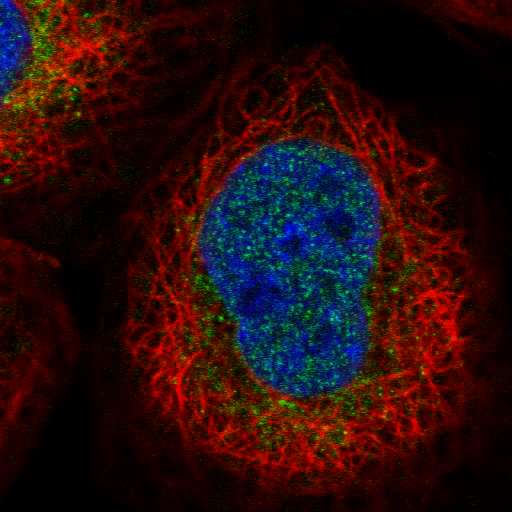

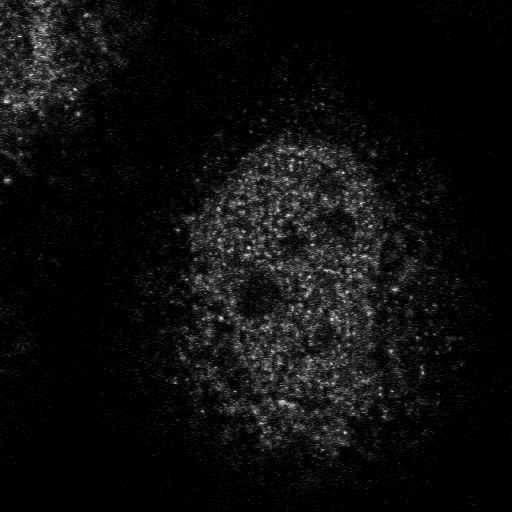

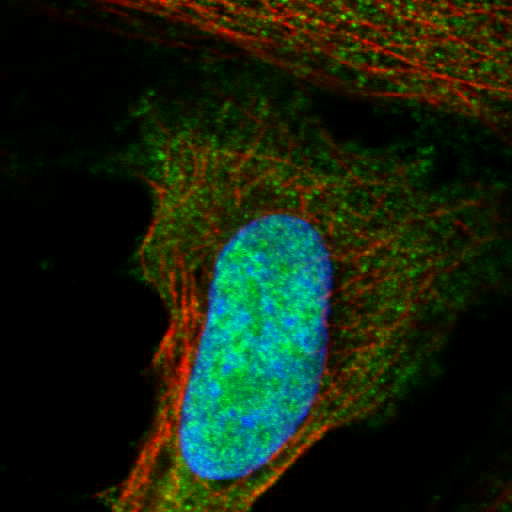

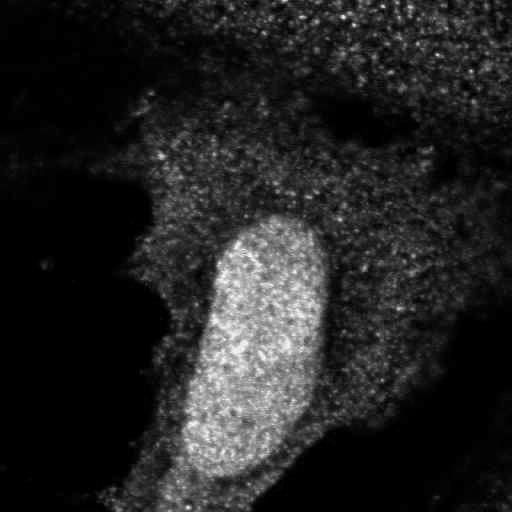

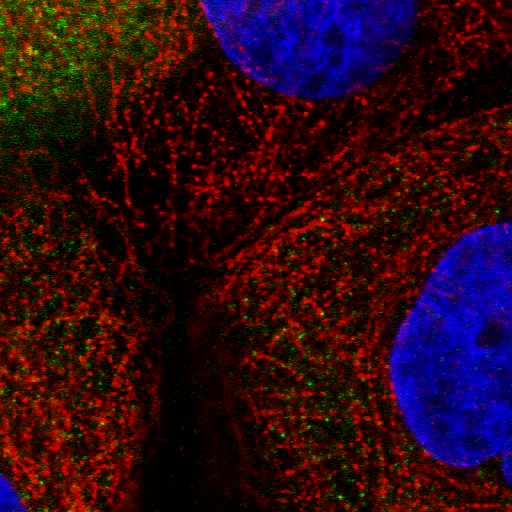

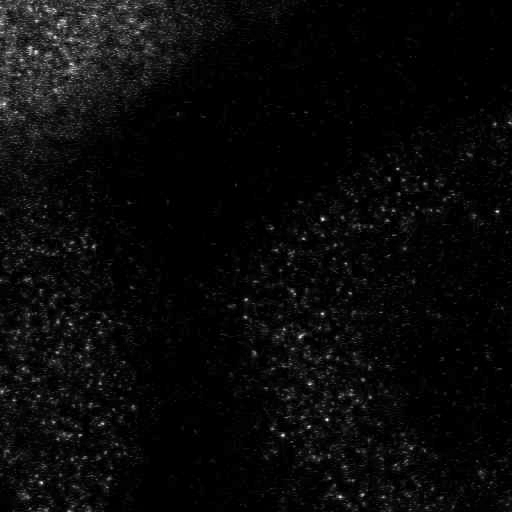

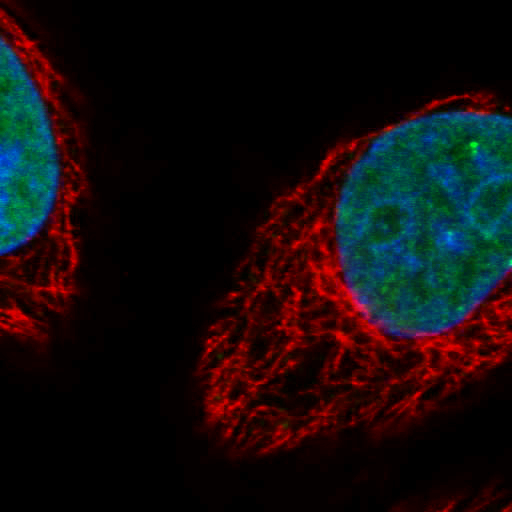

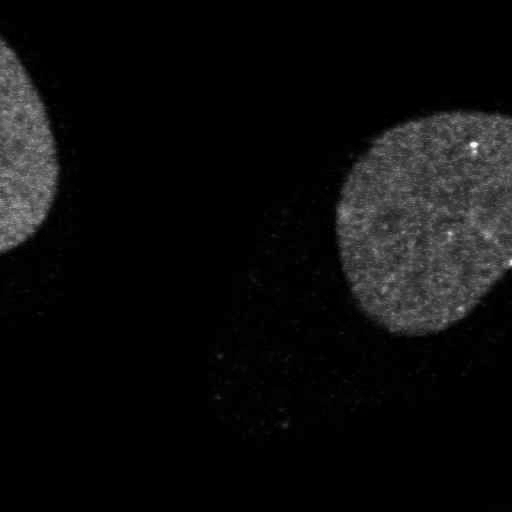

In [154]:
def torch_to_PIL_single_image(x, mode='RGB'):
    x = x.numpy().transpose(1,2,0)
    for i,c in enumerate(tuple(mode)):
        x[:,:,i] -= np.min(x[:,:,i])
        if np.max(x[:,:,i]) > 0:
            x[:,:,i] /= np.max(x[:,:,i])/255
    x = np.squeeze(x) if len(mode) == 1 else x
    return Image.fromarray(x.astype(np.uint8), mode=mode)

for i in range(dloader.batch_size):
    display(torch_to_PIL_single_image(minibatch['inputImage'][i], mode='RGB'))
    display(torch_to_PIL_single_image(minibatch['targetImage'][i], mode='L'))

In [11]:
d = {'a':2, 'b':2}
all([v==2 for k,v in d.items()])

True

In [148]:
from pytorch_learning_tools.data_providers.DataProviderABC import DataProviderABC
from pytorch_learning_tools.utils.hashsplit import hashsplit

# This is the dataframe-image dataprovider
class DataframeDataProvider(DataProviderABC):
    """PIL image dataframe dataprovider"""
    def __init__(self, df,
                 datasetClass=DatasetDataframe,
                 split_fracs={'train': 0.8, 'test': 0.2},
                 split_seed=1,
                 uniqueID='uniqueID',
                 dataset_kwargs={split:{'tabularData':{'outName1':'colName1', 'outName2':'colName2', 'uniqueID':'uniqueIDcol'},
                                        'imageData':{'image1':{'cols':['channel1colName', 'channel2colName']}, 'image2':{'cols':['RGBimagecolName']}}}
                                 for split in ('train', 'test')},
                 dataloader_kwargs={split:{'batch_size':8, 'shuffle':True, 'drop_last':True, 'num_workers':4, 'pin_memory':True}
                                    for split in ('train', 'test')}):
        """
        Args:
            df (pandas.DataFrame): dataframe containing the relative image locations and target data
            datasetClass (DataframeDataset*): specific class you want to wrap in a dataprovider
            split_fracs (dict): names of splits desired, and either a list of indices per split or a fracion of data in each split
            split_seed (int): random seed/salt for splitting has function, ignored if lists of inds are provided
            uniqueID (string): column name of coumn in df containing a unique id for each row
            dataset_kwargs: dict of keyword args for dataset; keys/values change depending on which type of DataframeDataset is desired
            dataloader_kwargs: dict of keyword args for Pytorch DataLoader class
            
        Notes: - The onus is on the user to make sure the data is actually present and in good shape
               - you MUST have a uniqueID column in the dataframe
        """
        self.opts = locals()
        self.opts.pop('self')
        self.opts.pop('df')

        df = df.reset_index(drop=True)
        self._unique_id_col = uniqueID
    
        # split the data into the different sets: test, train, valid, whatever
        # use dict of list of explicit inds if provided, otherwise split by hashing
        if all([isinstance(v,list) for k,v in split_fracs.items()]):
            self._split_inds = split_fracs
        else:
            self._split_inds = hashsplit(df[self._unique_id_col], splits=split_fracs, salt=split_seed)

        # split dataframe by split inds
        dfs = {split:df.iloc[inds].reset_index(drop=True) for split,inds in self._split_inds.items()}

        # load up all the datasets
        self._datasets = {split:datasetClass(df_s, **dataset_kwargs[split]) for split,df_s in dfs.items()}

        # save dfs as an accessable dict
        self.dfs = {split:dset.df for split,dset in self._datasets.items()}

        # create data loaders to efficiently iterate though the split datasets
        self.dataloaders = {split:DataLoader(dset, **dataloader_kwargs[split]) for split, dset in self._datasets.items()}

        # save a map from unique ids to splits + inds
        splits2indsuids = {split:tuple(zip(df_s[self._unique_id_col],df_s.index)) for split,df_s in self.dfs.items()}
        self._uids2splitsinds = {uid:(split,ind) for split in splits2indsuids for (uid,ind) in splits2indsuids[split]}

    @property
    def splits(self):
        return self._split_inds

    def _get_single_item(self, unique_id):
        split, ind = self._uids2splitsinds[unique_id]
        return self._datasets[split]._get_single_item(ind)

    def __getitem__(self, uids):
        return collate([self._get_single_item(u) for u in uids]) if (isinstance(idx, Iterable) and not isinstance(L, str)) else self._get_single_item(uids)

In [149]:
df['uniqueIDcol'] = df.index

In [150]:
dataset_kwargs={split:{'tabularData':{'antigenSequence':'antigenSequence', 'EnsemblID':'EnsemblID', 'uniqueID':'uniqueIDcol'},
                       'imageData':{'inputImage':{'cols':['microtubuleChannel', 'antibodyChannel', 'nuclearChannel'],
                                                  'loader':partial(loadPILImages, mode='L'),
                                                  'transform':transforms.Compose([transforms.ToPILImage(),transforms.CenterCrop(IM_SIZE),transforms.ToTensor()])},
                       'targetImage':{'cols':['antibodyChannel'],
                                      'loader':partial(loadPILImages, mode='L'),
                                      'transform':transforms.Compose([transforms.ToPILImage(),transforms.CenterCrop(IM_SIZE),transforms.ToTensor()])}}}
                       for split in ('train', 'test')}

dataloader_kwargs={split:{'batch_size':4, 'shuffle':True, 'drop_last':True, 'num_workers':4, 'pin_memory':True} for split in ('train', 'test')}

dp = DataframeDataProvider(df, uniqueID='uniqueIDcol', dataset_kwargs=dataset_kwargs, dataloader_kwargs=dataloader_kwargs)

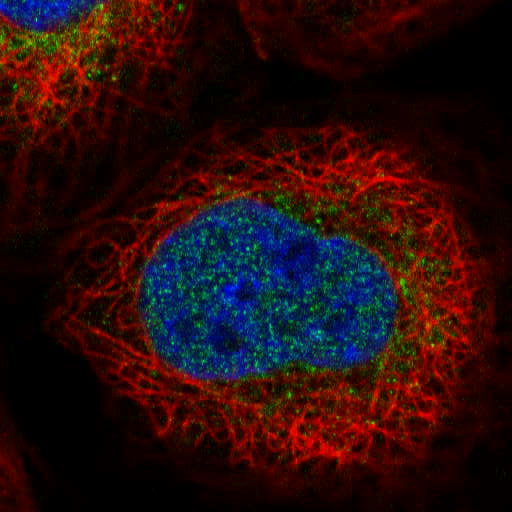

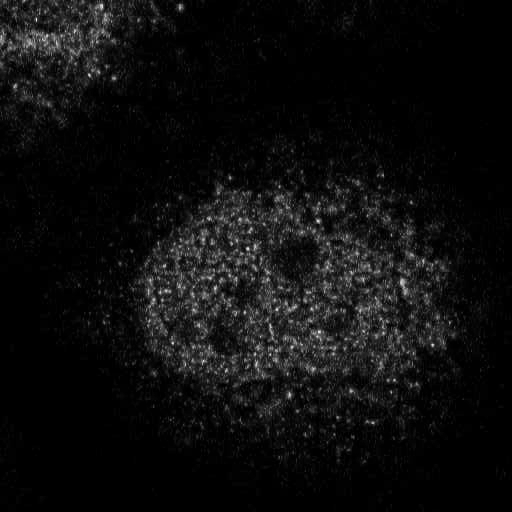

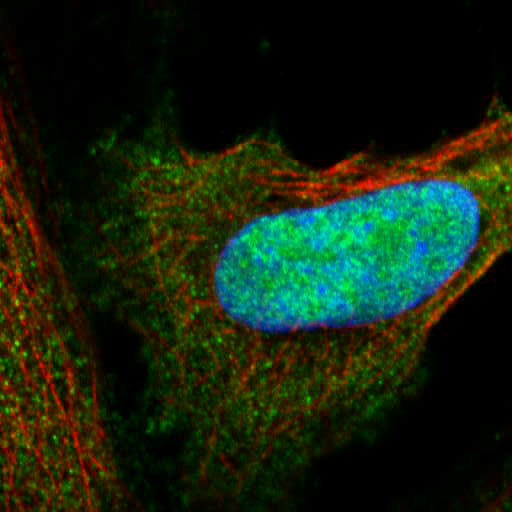

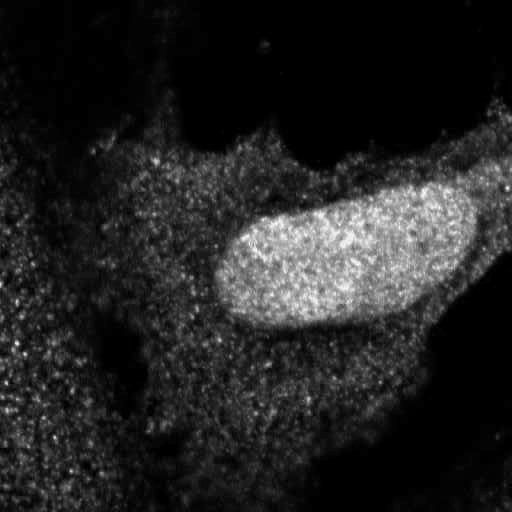

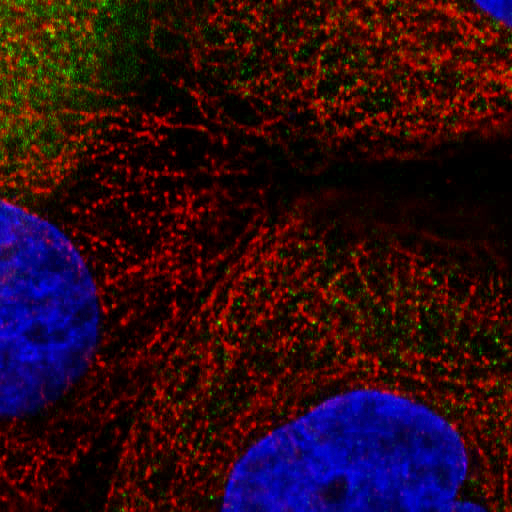

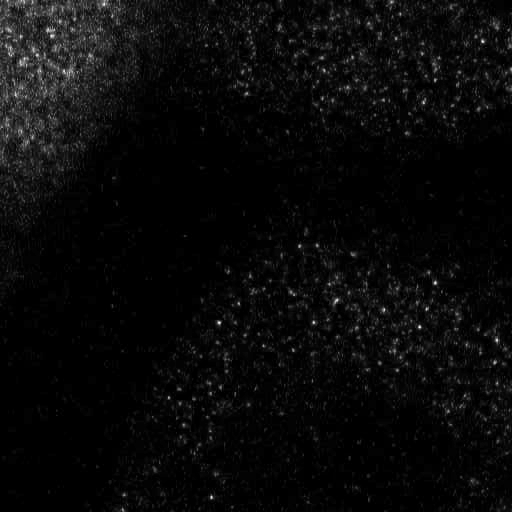

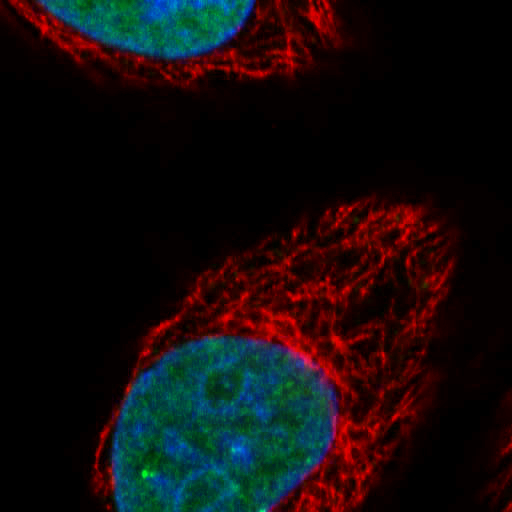

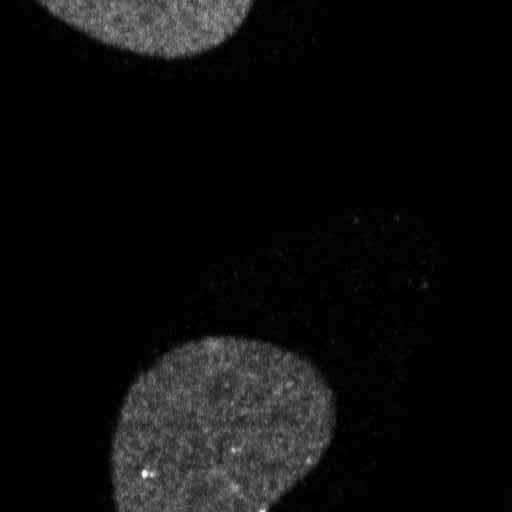

In [151]:
i,minibatch = next(enumerate(dp.dataloaders['train']))

for i in range(dloader.batch_size):
    display(torch_to_PIL_single_image(minibatch['inputImage'][i], mode='RGB'))
    display(torch_to_PIL_single_image(minibatch['targetImage'][i], mode='L'))

In [152]:
IM_SIZE=512; mask=torch.ones([3,IM_SIZE,IM_SIZE]); mask[1,:,:]=0

dataset_kwargsHPA = {'inputImageCols':['microtubuleChannel', 'antibodyChannel', 'nuclearChannel'],
                     'inputImageTransform':transforms.Compose([transforms.ToPILImage(),transforms.CenterCrop(IM_SIZE),transforms.ToTensor(), transforms.Lambda(lambda x: mask*x)]),
                     'targetImageTransform':transforms.Compose([transforms.ToPILImage(),transforms.CenterCrop(IM_SIZE),transforms.ToTensor()])}
dataloader_kwargs = {'batch_size':4, 'shuffle':True, 'drop_last':True, 'num_workers':4, 'pin_memory':True}

dataset_kwargsHPA = {split:dataset_kwargsHPA for split in ('train', 'test')}
dataloader_kwargs={split:dataloader_kwargs for split in ('train', 'test')}

dp = DataframeDataProvider(df, datasetClass=DatasetHPA, uniqueID='uniqueIDcol', dataset_kwargs=dataset_kwargsHPA, dataloader_kwargs=dataloader_kwargs)

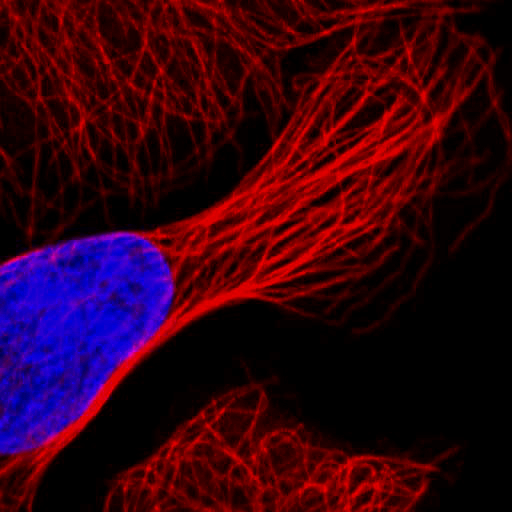

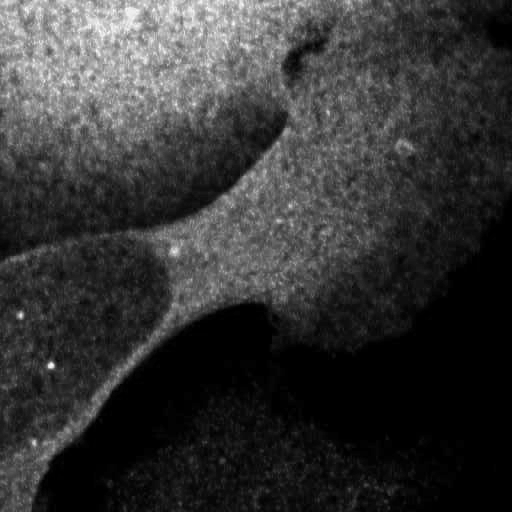

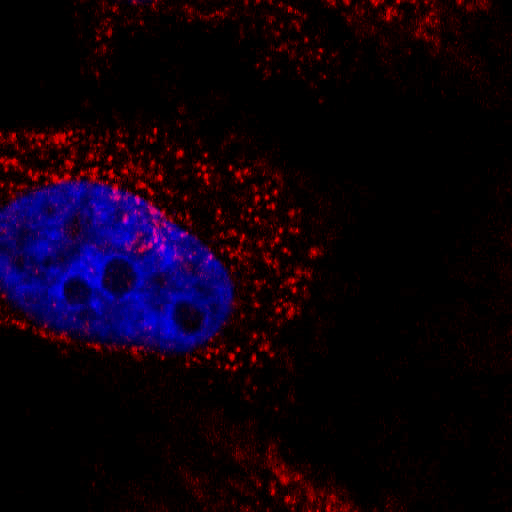

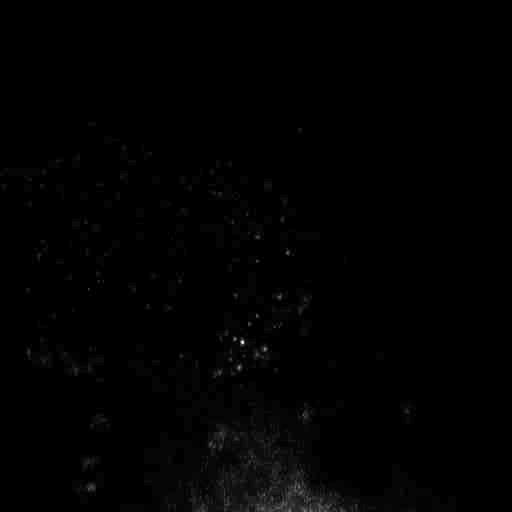

In [153]:
i,m = next(enumerate(dp.dataloaders['test']))
for i in range(2):
    display(torch_to_PIL_single_image(m['inputImage'][i], mode='RGB'))
    display(torch_to_PIL_single_image(m['targetImage'][i], mode='L'))